In [71]:
import numpy as np

#TIS-Ecoli
sequences_file = open("TIS-Ecoli.txt", "r")
sequences_list=[]
for i in sequences_file.readlines():
    sequences_list.append(i)

sequences_arr = np.array(sequences_list, dtype=str)
print(sequences_arr[0][100:104])


ATGA


finding the position of start codons and counting the frequency

false codon 6230  true codon 720
Positions of start codon in each sequence: {0: [53, 80, 116, 122, 134], 1: [137], 2: [61, 113, 119, 137, 142], 3: [30, 122, 156], 4: [25, 188], 5: [24, 143, 182], 6: [2, 29, 121, 125, 139], 7: [2, 7, 32, 136, 179], 8: [3, 149, 188], 9: [27, 80, 188], 10: [24, 128], 11: [7, 36, 39, 46], 12: [25, 37, 83, 119, 125, 152, 158, 164], 13: [0], 14: [56, 113, 134], 15: [19, 62, 116, 119, 164], 16: [24, 40, 116], 17: [83, 96, 158], 18: [0, 22, 58, 106], 19: [83, 170], 20: [10, 41, 143, 170], 21: [15, 145], 22: [103, 113, 173], 23: [37, 78, 194], 24: [46, 122], 25: [83, 107, 113, 125, 148], 26: [0, 64, 176], 27: [25, 56, 79, 125, 136, 154], 28: [34, 124, 182], 29: [22, 51, 71, 107], 30: [3, 16, 29, 176], 31: [32, 140], 32: [5, 31, 58, 73], 33: [52, 161], 34: [39, 72, 196], 35: [3, 23, 70, 146, 168], 36: [57, 116, 146], 37: [4, 40, 82, 92, 187], 38: [28, 116], 39: [131], 40: [13, 119, 167, 185], 41: [15, 184], 42: [51, 60, 163], 43: [14, 30, 95, 134], 44: [128, 158

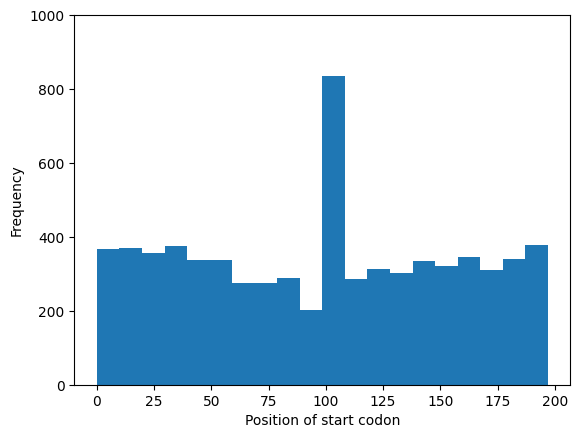

In [72]:
import re
import matplotlib.pyplot as plt

# Dictionary to store positions of the substring for each sequence
positions = {}
true_codon=0
false_codon=0
# for creating a histogram of the data we create a list of all the postins and then 
# turn in to a np array
true_positive_seq=[]
his_array=[]
# Loop through each DNA sequence and search for the substring
codons=["ATG", "GTG","TTG"]
for start_codon in codons:
    for i, sequence in enumerate(sequences_arr):
        matches = [match.start() for match in re.finditer(start_codon, sequence)]
        his_array.extend(matches)
        if 100 in matches:
            true_positive_seq.append(sequence)
            true_codon+=1
            false_codon=false_codon+len(matches)-1
        else:
            false_codon=false_codon+len(matches)
        positions[i] = matches

print("false codon",false_codon, " true codon",true_codon)
print("Positions of start codon in each sequence:", positions)

his_array=np.array(his_array)

# histogram ploting
plt.hist(his_array, bins=20)
plt.xlabel("Position of start codon")
plt.ylabel("Frequency")
plt.ylim(0, 1000)
plt.show()

**PWM Generation function**

In [73]:
from math import log
import numpy as np

def calculate_pwm(sequences_arr, region_start, region_end, pseudocount, background_model):

    L = region_end - region_start  # Length of the region

    # Extracting the specified region from the sequences
    regions = np.array([list(seq[region_start:region_end]) for seq in sequences_arr])

    # Creating boolean arrays for each nucleotide true means the nuclotide exists there and false means it doesn't
    base_matrices = {
        'A': (regions == 'A'),
        'C': (regions == 'C'),
        'G': (regions == 'G'),
        'T': (regions == 'T')
    }

    # Counting the occurrence of each nucleotide at each position
    A_counts = np.sum(base_matrices['A'], axis=0)
    T_counts = np.sum(base_matrices['T'], axis=0)
    C_counts = np.sum(base_matrices['C'], axis=0)
    G_counts = np.sum(base_matrices['G'], axis=0)

    # Concatenating counts into a single array (initial PWM)
    PWM = np.vstack((A_counts, T_counts, C_counts, G_counts)).astype(float)

    # Calculate column sums
    column_sums = PWM.sum(axis=0)

    # Calculate log odds ratio for each position and nucleotide
    for pos in range(L):
        for nucleotide in range(4):
            a = (PWM[nucleotide][pos] + pseudocount)  # Add pseudocount
            a /= (column_sums[pos] + 4 * pseudocount)  # Normalize
            PWM[nucleotide][pos] = log(a, 2) - log(background_model, 2)  # Log odds ratio

    return PWM


constructing PWM 

In [74]:
# true positives are the ones with start codon at 101
true_positive_seq= np.array(true_positive_seq, dtype=str)
#print(true_positive_seq)
pwm=calculate_pwm(true_positive_seq, 70, 100, 1,0.25)
print(pwm)
# row 1:A, row2:T, row3:C, row4:G

[[ 0.16549003  0.11486396  0.19364107  0.00794875  0.21439963  0.12951073
   0.25504162  0.27494117  0.35190315  0.29456998  0.42496662  0.38889736
   0.49450755  0.53357711  0.47169767  0.41901735  0.47743404  0.62943713
   0.5390731   0.46015604  0.38889736  0.34564416  0.69982646  0.5169624
   0.55543655  0.50015411  0.55000266  0.82208221  0.1440103   0.12951073]
 [ 0.28805667  0.03153557  0.12220593  0.17963421  0.12220593  0.17257945
   0.12220593  0.11486396  0.1583656   0.29456998  0.03931292  0.18665464
   0.22807457  0.12951073  0.1440103   0.12951073 -0.14229388 -0.2710272
  -0.54564958 -1.2710272  -1.37056287 -1.29039252 -0.99205125 -0.36029453
   0.03931292  0.11486396  0.07000972 -0.71848617  0.37051883  0.11486396]
 [-0.15111773 -0.01603011  0.05474296 -0.04863478  0.07758294 -0.17791779
  -0.07358113 -0.06521766 -0.12480646 -0.24245804 -0.30017354 -0.13352367
  -0.31002133 -0.30017354 -0.26144115 -0.45545177 -0.56910855 -0.61720284
  -0.92999028 -1.45545177 -2.14229388 

scoring function

In [75]:
# scoring  sequences
# row 1:A, row2:T, row3:C, row4:G
def scoring(sequence, pwm):
    total_score = 0  
    pwm_length = pwm.shape[1] 


    for i in range(min(len(sequence), pwm_length)):
        if sequence[i] == "A":
            total_score += pwm[0, i]
        elif sequence[i] == "T":
            total_score += pwm[1, i]
        elif sequence[i] == "C":
            total_score += pwm[2, i]
        elif sequence[i] == "G":
            total_score += pwm[3, i]
    
    return total_score



scoring true positives and defining treshold of 50%

In [76]:
tp_score=[]
regions = np.array([list(seq[70:100]) for seq in true_positive_seq])
for seq in regions:
    tp_score.append(scoring(seq, pwm))

print(tp_score)

def find_threshold_for_tpr(true_scores, target_tpr):
    """
    Find threshold that achieves target true positive rate
    """
    if not true_scores:  # Check if list is empty
        raise ValueError("No scores provided - true_scores list is empty")
    
    sorted_scores = sorted(true_scores, reverse=True)
    index = int(len(sorted_scores) * target_tpr)
    
    # Ensure index is valid
    if index >= len(sorted_scores):
        return sorted_scores[-1]  # Return the last score if index too large
    return sorted_scores[index]
treshold=find_threshold_for_tpr(tp_score, target_tpr=0.5)
print(treshold)

def calculate_false_positive_rate(negatives, pwm, threshold):

    # Score all sequences
    test_n_score = [scoring(seq, pwm) for seq in negatives]
    test_n_score.sort(reverse=True)  # Sort scores in descending order

    # Count false positives
    false_positives = sum(score >= threshold for score in test_n_score)

    # Calculate and return FPR
    return false_positives / len(test_n_score) if test_n_score else 0

def calculate_false_negative_rate(positives, pwm, threshold):

    # Score all sequences
    test_p_score = [scoring(seq, pwm) for seq in positives]
    test_p_score.sort()  # Sort scores in ascending order

    # Count false negatives (scores below or equal to the threshold)
    false_negatives = sum(score <= threshold for score in test_p_score)

    # Calculate and return FNR
    return false_negatives / len(test_p_score) if test_p_score else 0


[1.95623625383419, 2.4898777787270445, -0.08960177548408765, 0.058055966049102015, 6.950253010014052, 3.5311319011811135, 1.2873959813085938, 2.0787002431176154, 0.1697439407675203, -2.059823070080005, 4.90935707827191, 4.514801238412528, 6.617958691621919, 5.910937931852605, 1.801716548798949, 4.134400228576734, 4.009879536434948, 4.670125551584373, 0.5189617269210409, 5.712348158440019, 2.2912050456474593, 3.5243697710757007, 4.863755198798539, 1.4259954430809842, 4.410350634878943, 1.0365201700736093, 1.9655993359782276, 1.1830938833722964, 0.3115932819215328, 4.410556520349336, 1.9908065374178632, 1.2734963434671738, 0.2726645240814036, 5.69794648320676, 2.16434544572655, 1.6162379050667965, 3.286209189596359, 5.287085909421982, 2.2462210627659305, 1.2114508653768263, 0.9304785378579223, 1.1259604063065043, 1.7898779774172824, 2.8349302184812646, 3.6343317031693587, 7.956978811929272, 4.481404656747508, 2.933221156347111, 4.71989237164621, 2.207066894674134, 2.5489953690790568, 4.9

finding false positive rate

In [77]:
#filtering false positive positions

false_positive = {}
for key, values in positions.items():
    # Filter values less than 29 and not equal to 100
    filtered_values = [value for value in values if  value>29 and value != 100]
    false_positive[key] = filtered_values
print(false_positive)


# exctracting false positive sequences
false_positive_l=[]
for seq,pos in false_positive.items():
    for p in pos:
        #print(p,(p-30))
        false_positive_l.append(sequences_arr[seq][p-30:p])

false_positive_seq=np.array(false_positive_l, dtype=str)
FPR_1=calculate_false_positive_rate(false_positive_seq, pwm, treshold)
print("FPR",FPR_1)

{0: [53, 80, 116, 122, 134], 1: [137], 2: [61, 113, 119, 137, 142], 3: [30, 122, 156], 4: [188], 5: [143, 182], 6: [121, 125, 139], 7: [32, 136, 179], 8: [149, 188], 9: [80, 188], 10: [128], 11: [36, 39, 46], 12: [37, 83, 119, 125, 152, 158, 164], 13: [], 14: [56, 113, 134], 15: [62, 116, 119, 164], 16: [40, 116], 17: [83, 96, 158], 18: [58, 106], 19: [83, 170], 20: [41, 143, 170], 21: [145], 22: [103, 113, 173], 23: [37, 78, 194], 24: [46, 122], 25: [83, 107, 113, 125, 148], 26: [64, 176], 27: [56, 79, 125, 136, 154], 28: [34, 124, 182], 29: [51, 71, 107], 30: [176], 31: [32, 140], 32: [31, 58, 73], 33: [52, 161], 34: [39, 72, 196], 35: [70, 146, 168], 36: [57, 116, 146], 37: [40, 82, 92, 187], 38: [116], 39: [131], 40: [119, 167, 185], 41: [184], 42: [51, 60, 163], 43: [30, 95, 134], 44: [128, 158], 45: [30, 74, 84, 164, 188], 46: [81, 110, 164], 47: [36, 113, 143], 48: [107, 146], 49: [74, 82, 133, 191], 50: [30, 38, 104, 197], 51: [45, 114, 130, 165, 188], 52: [32, 56, 65, 76, 146,

traning on the first 400 sequences

In [ ]:
#calculate_pwm(sequences_arr, region_start, region_end, pseudocount, background_model
pwm_400=calculate_pwm(true_positive_seq[0:400],70,100,1,0.25)
print(pwm_400)
tp_scores=[]

for i in true_positive_seq[0:400]:
    tp_scores.append(scoring(i,pwm_400))

treshold_400=find_threshold_for_tpr(tp_scores[0:400], target_tpr=0.5)

test_negatives = np.setdiff1d(sequences_arr, true_positive_seq)
test_positives=true_positive_seq[400::]


fp_score=[]
for seq in test_negatives:
    fp_score.append(scoring(seq,pwm_400))



fpr_400=calculate_false_positive_rate(test_negatives,pwm_400,treshold_400)
tpr_400=calculate_false_positive_rate(test_positives,pwm_400,treshold_400)


print(tpr_400,fpr_400) 
# FPR_400=false_positive400/len(test_n_score)
# TPR_400=(len(test_p_score)-false_negative400)/len(test_p_score)


[[ 0.21215324  0.22443157  0.27252585  0.04222824  0.23660628  0.17467853
   0.35301577  0.34178852  0.39707095  0.40787771  0.46072959  0.35301577
   0.42925136  0.48133987  0.47107153  0.47107153  0.52169761  0.63640927
   0.61791292  0.49153564  0.49153564  0.38618264  0.69051667  0.61791292
   0.48133987  0.56095704  0.57060721  0.75964103 -0.01435529  0.0832555 ]
 [ 0.3075728   0.04222824  0.21215324  0.09667602  0.01421386  0.16196748
   0.12314823  0.0832555   0.13620438  0.27252585  0.          0.0832555
   0.28430302  0.09667602  0.10997284  0.14914344 -0.23194673 -0.15041684
  -0.61381736 -1.37280926 -1.30065948 -1.44875812 -1.10362263 -0.61381736
   0.          0.01421386 -0.01435529 -0.61381736  0.35301577  0.18727857]
 [-0.16635839 -0.10362263 -0.18247805  0.06970897  0.16196748 -0.16635839
  -0.05829864 -0.11905267 -0.18247805 -0.21526799 -0.30065948 -0.10362263
  -0.26589406 -0.19877986 -0.26589406 -0.44875812 -0.57074864 -0.63584367
  -0.75132089 -1.37280926 -2.01435529

ROC curve for pwm400

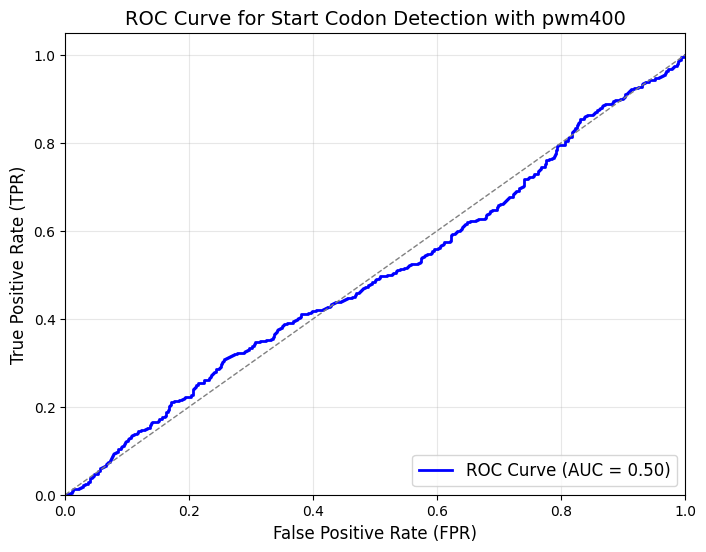

In [ ]:


true_scores = np.array(tp_scores)  # Scores for true start codon candidates
false_scores = np.array(fp_score)  # Scores for false start codon candidates


from sklearn.metrics import roc_curve, auc
# Combine scores and labels
scores = np.concatenate((true_scores, false_scores))
labels = np.concatenate((np.ones(len(true_scores)), np.zeros(len(false_scores))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Start Codon Detection with pwm400', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

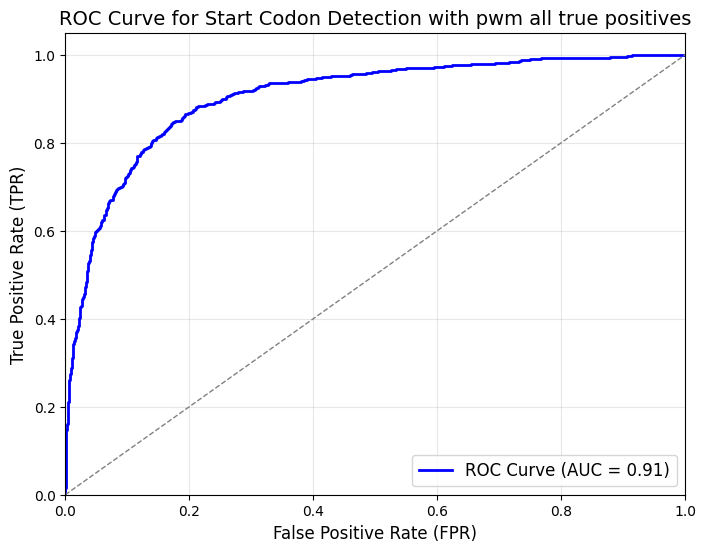

In [86]:
false_positive_seq=np.array(false_positive_l, dtype=str)
fp_score=[]
for seq in false_positive_seq:
    fp_score.append(scoring(seq,pwm))
true_scores = np.array(tp_score)  # Scores for true start codon candidates
false_scores = np.array(fp_score)  # Scores for false start codon candidates


#from sklearn.metrics import roc_curve, auc
# Combine scores and labels
scores = np.concatenate((true_scores, false_scores))
labels = np.concatenate((np.ones(len(true_scores)), np.zeros(len(false_scores))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Start Codon Detection with pwm all true positives', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

by comparing the AUC metrics for pwm models we can concolude that the pwm genrated by all true positives not just the first 400 acts better. 

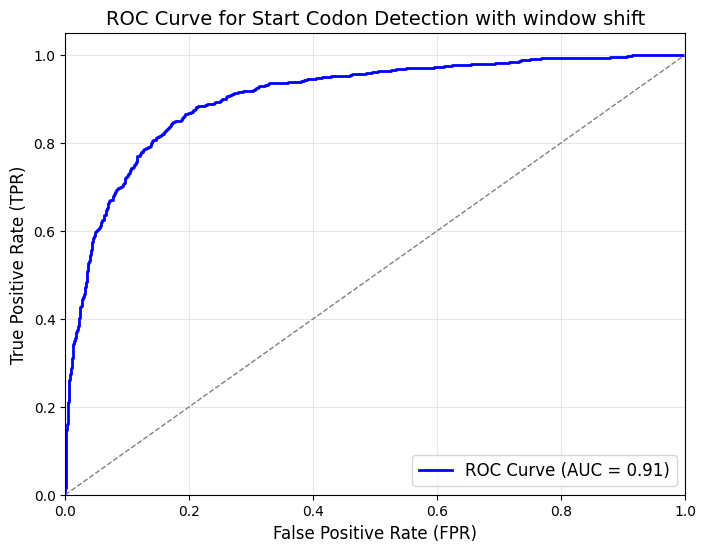

In [89]:
pwm_shift=calculate_pwm(true_positive_seq, 69, 101, 1, 0.25)

tp_score=[]
regions1 = np.array([list(seq[69:101]) for seq in true_positive_seq])
for seq in regions1:
    tp_score.append(scoring(seq, pwm_shift))


# exctracting false positive sequences
false_positive_l=[]
for seq,pos in false_positive.items():
    for p in pos:
        #print(p,(p-30))
        false_positive_l.append(sequences_arr[seq][p-29:p+1])
false_positive_seq1=np.array(false_positive_l, dtype=str)
fp_score=[]
for seq in false_positive_seq1:
    fp_score.append(scoring(seq,pwm_shift))

#from sklearn.metrics import roc_curve, auc
# Combine scores and labels
scores = np.concatenate((true_scores, false_scores))
labels = np.concatenate((np.ones(len(true_scores)), np.zeros(len(false_scores))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Start Codon Detection with window shift', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


working with a shifted window works slightly better

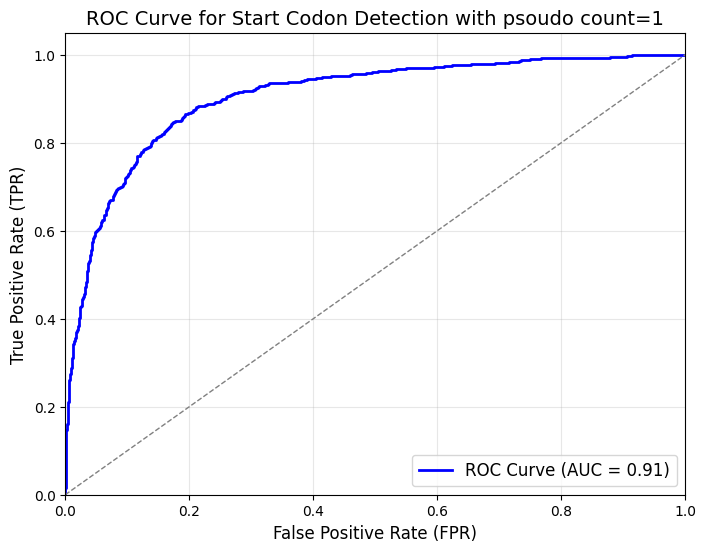

In [ ]:
pwm_ps1=calculate_pwm(true_positive_seq, 69, 101, .1, 0.25)

tp_score=[]
for seq in regions:
    tp_score.append(scoring(seq, pwm_ps1))


fp_score=[]
for seq in false_positive_seq:
    fp_score.append(scoring(seq,pwm_ps1))


#from sklearn.metrics import roc_curve, auc
# Combine scores and labels
scores = np.concatenate((true_scores, false_scores))
labels = np.concatenate((np.ones(len(true_scores)), np.zeros(len(false_scores))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Start Codon Detection with psoudo count=.1', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

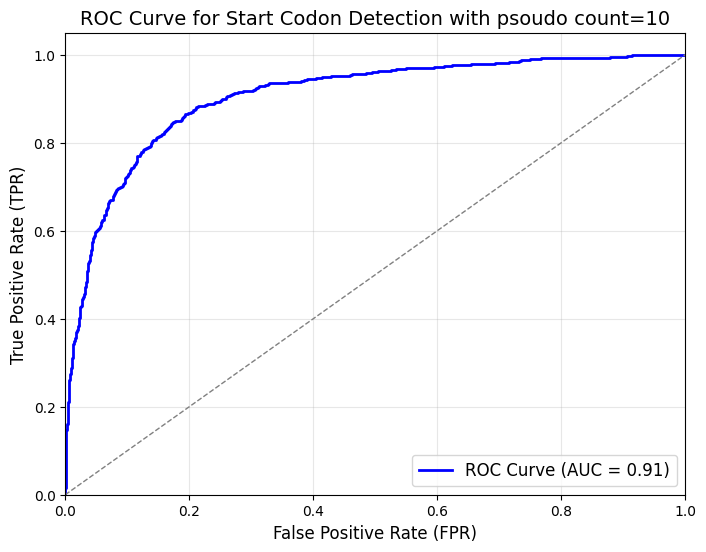

In [91]:
pwm_ps1=calculate_pwm(true_positive_seq, 69, 101, 10, 0.25)

tp_score=[]
for seq in regions:
    tp_score.append(scoring(seq, pwm_ps1))


fp_score=[]
for seq in false_positive_seq:
    fp_score.append(scoring(seq,pwm_ps1))


#from sklearn.metrics import roc_curve, auc
# Combine scores and labels
scores = np.concatenate((true_scores, false_scores))
labels = np.concatenate((np.ones(len(true_scores)), np.zeros(len(false_scores))))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Start Codon Detection with psoudo count=10', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

well it seems changing the pseudo count is not so significant

for modifying the model a more realidtic background model that for instance models all non coding sequences would be better